# Base VAE (BCE)

In [33]:
from pathlib import Path

import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

import matplotlib.pyplot as plt
import numpy as np

import pmldiku
from pmldiku import data, vae, model_utils

%load_ext autoreload
%autoreload 1
%aimport pmldiku, pmldiku.data, pmldiku.vae, pmldiku.model_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
torch.manual_seed(1)

CUDA = True
BATCH_SIZE = 128
LOGPX_LOSS = "bce"
DEVICE_NAME = "cuda" if CUDA else "cpu"

DEVICE = torch.device(DEVICE_NAME)
kwargs = {'num_workers': 4, 'pin_memory': DEVICE} 

In [4]:
# Val equals test here :)
train_loader = data.load_mnist(train=True).setup_data_loader(batch_size=BATCH_SIZE, **kwargs)
val_loader = data.load_mnist(train=False).setup_data_loader(batch_size=BATCH_SIZE, **kwargs)  

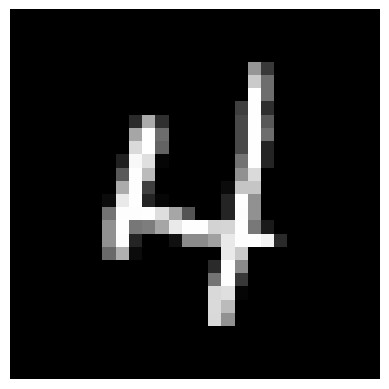

In [5]:
X, y = next(iter(train_loader))
img = X[0].squeeze().numpy()
model_utils.plot_img(img)

# Train model

In [10]:
# Model
base_vae = vae.BaseVAE()
model = vae.LitVAE(vae=base_vae, logpx_loss=LOGPX_LOSS)

# Callbacks
loss_callback = vae.VAELossCallback()
reconstruct_cb = vae.VAEImageReconstructionCallback()
cb_checkpoint = ModelCheckpoint(
    dirpath=pmldiku.FP_MODELS,
    filename='mnist-VAE-BCE-{epoch:02d}-{val_loss:.2f}'
)
cb_earlystopping = EarlyStopping(monitor="val_loss", mode="min")
callbacks = [loss_callback, reconstruct_cb, cb_checkpoint, cb_earlystopping]

# Trainer
trainer = pl.Trainer(max_epochs=-1, devices=1, accelerator=DEVICE_NAME, callbacks=callbacks)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [11]:
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name | Type    | Params
---------------------------------
0 | vae  | BaseVAE | 709 K 
---------------------------------
709 K     Trainable params
0         Non-trainable params
709 K     Total params
2.838     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

array([69537.390625  , 21267.828125  , 20413.10351562, 19923.00195312,
       19592.9375    , 19305.50976562, 19104.265625  , 19011.53125   ,
       18862.89648438, 18768.41015625, 18685.54101562, 18652.04492188,
       18607.109375  , 18546.27929688, 18502.953125  , 18404.109375  ,
       18423.5625    , 18409.99609375, 18324.1015625 , 18315.1875    ,
       18335.65625   , 18242.15429688, 18229.61523438, 18198.95117188,
       18199.85742188, 18172.30273438, 18143.53710938, 18129.80078125,
       18160.45898438, 18105.07226562, 18061.18945312, 18137.96289062,
       18028.734375  , 18078.88085938, 18032.75585938, 18057.59765625])

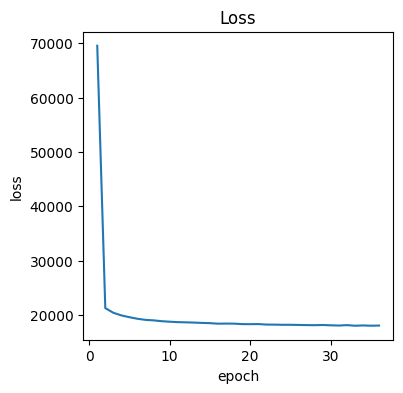

In [12]:
losses = np.array(loss_callback.val_loss)
model_utils.plot_loss(losses)
losses

# Reconstruction of model for each epoch of training

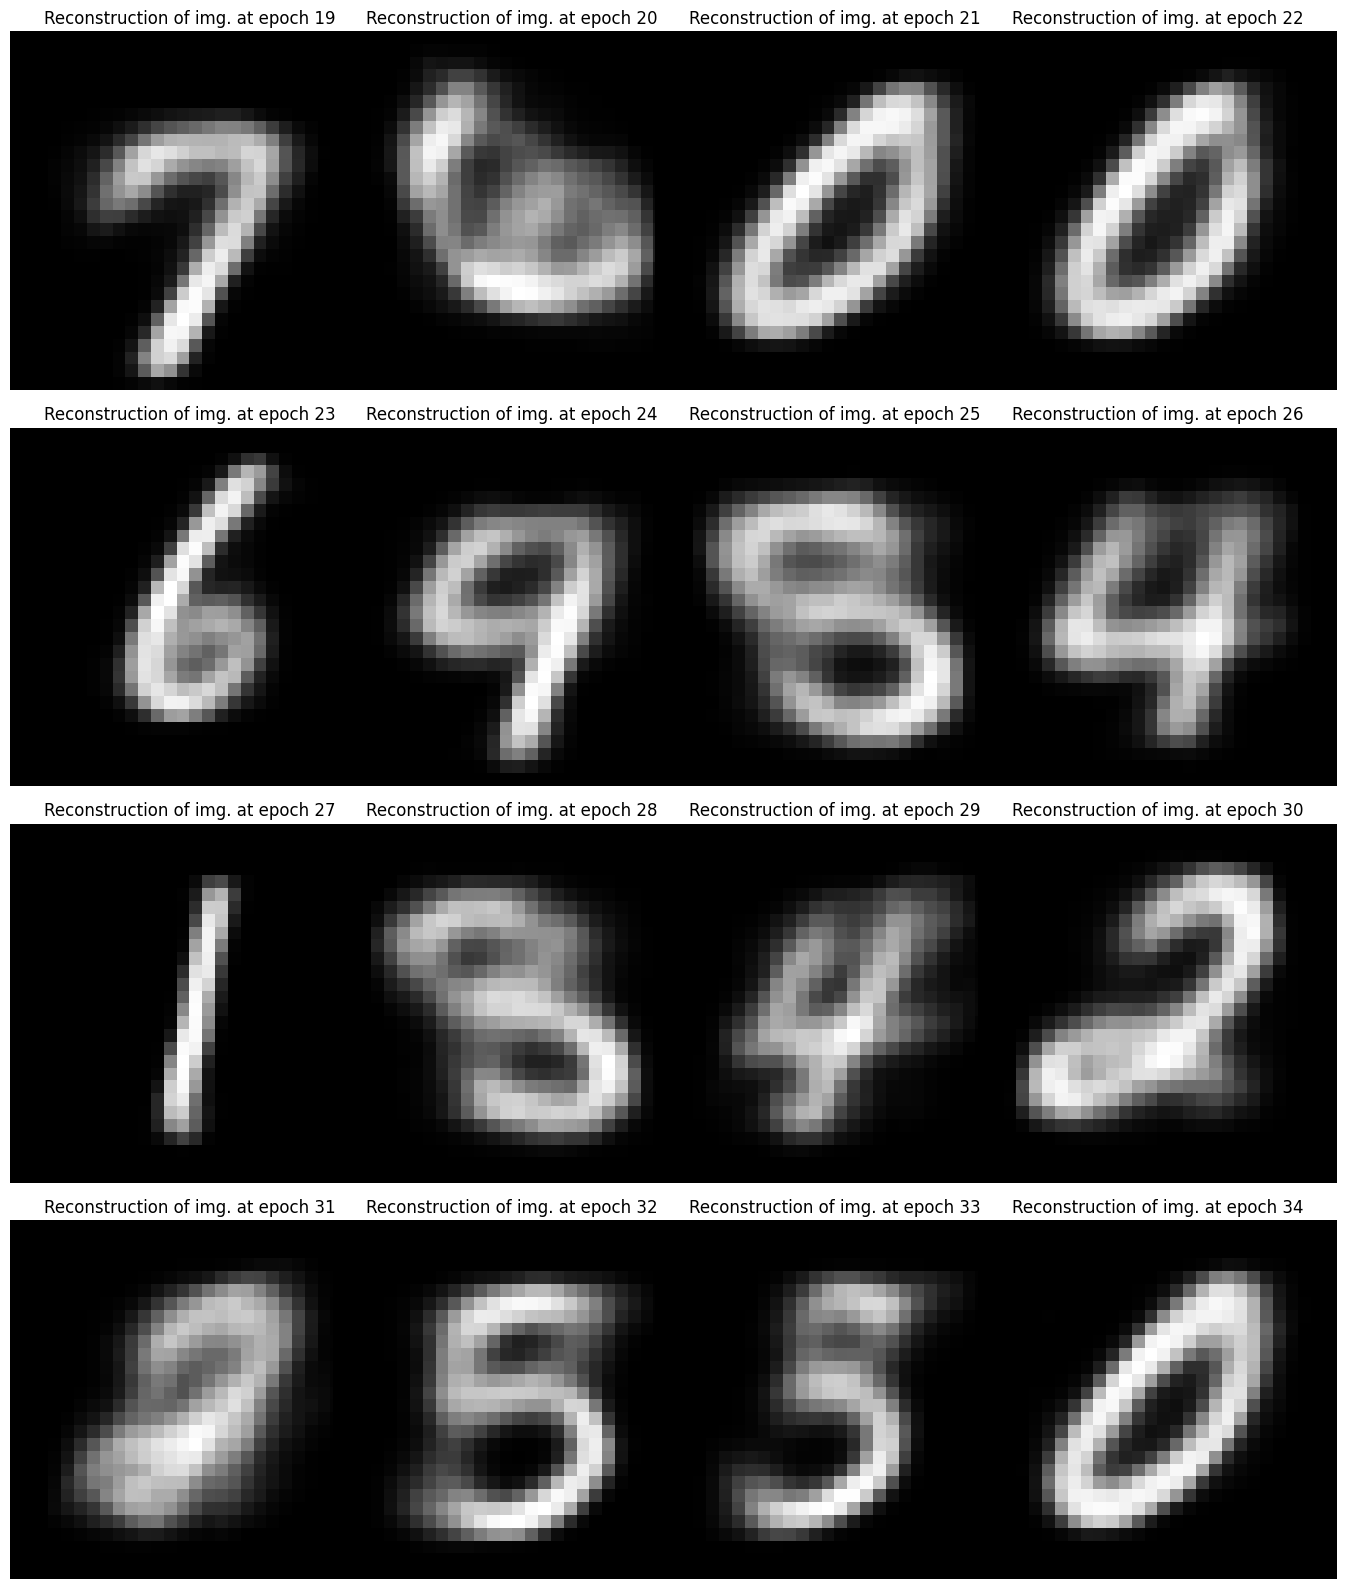

In [27]:
# Take first image of each batch of reconstructed images
images = reconstruct_cb.samples[-16:, 0, :, :].cpu().numpy()
start = cb_earlystopping.stopped_epoch - 16
model_utils.plot_image_reconstruction(images, num_cols=4, slim=20, start=start)

# Expected value in latent space for each number

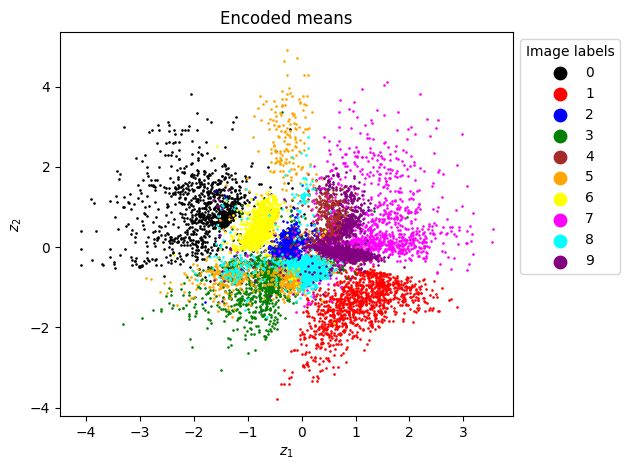

In [28]:
means_plot, labels = vae.encode_means(model.vae, val_loader)
plot_args = dict(title="Encoded means", xlabel=r"$z_1$", ylabel=r"$z_2$")
model_utils.plot_encoded(means_plot, labels, **plot_args)

# Reconstruction of equally spaced gaussian noise

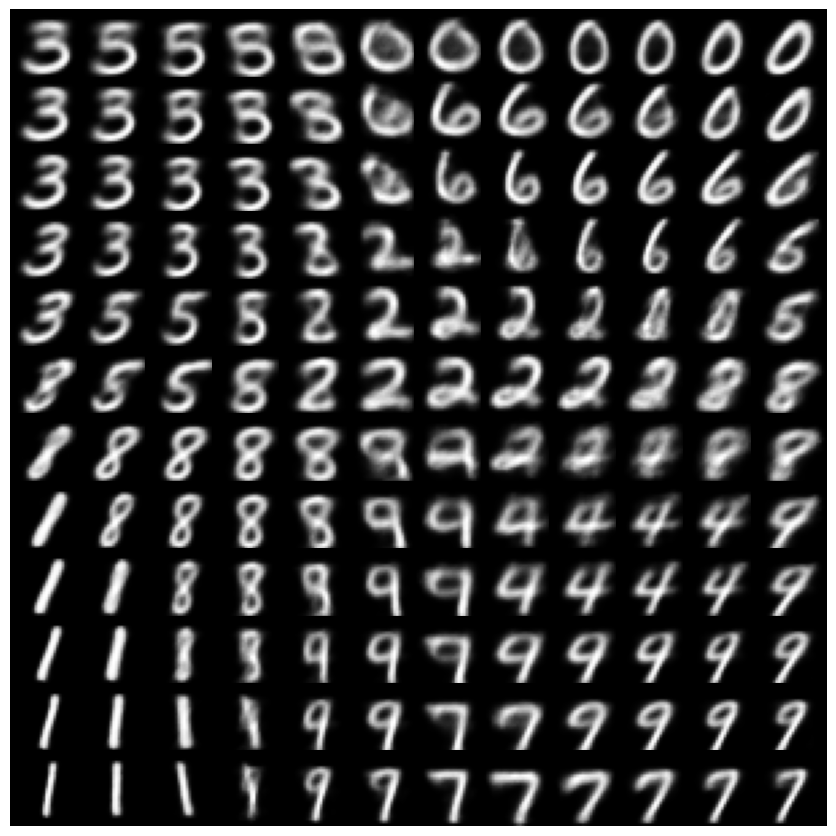

In [29]:
gauss_vals = model_utils.construct_gauss_grid(M=12)
decoded_imgs = model.vae.decode(gauss_vals).detach().numpy()
model_utils.plot_gauss_grid_imgs(decoded_imgs)